### В данном проекте мы сделаем предобработку и анализ данных,отбор признаков для построения модели и затем уже построим модель, которая будет предсказывать вероятность отмены бронирования номера в отеле.

#### Подгрузим необходимые библиотеки

In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')

sns.set(
    font_scale=2,
    style = 'whitegrid',
    rc = {'figure.figsize':(20,7)}
)

#### Импортируем и объединим данные

In [188]:
hotel_full = pd.read_csv('/Users/vladurich/Downloads/hotel.csv',index_col=0)
print(hotel_full.shape)

(109390, 32)


In [189]:
hotel_full.fillna(0, inplace=True)

#### Добавим новый признак, равный 1, если запрошенный и назначенный тип номера не совпадают

In [190]:
is_diff = []
col1 = hotel_full['reserved_room_type']
col2 = hotel_full['assigned_room_type']
for i,j in zip(col1,col2):
    if i == j:
        is_diff.append(0)
    else:
        is_diff.append(1)

In [191]:
hotel_full['is_diff'] = is_diff

#### Уберем неважные признаки

In [192]:
corr_df = np.abs(hotel_train.corr()['is_canceled']).sort_values(ascending=False) 

In [193]:
not_needed_features = corr_df[corr_df < 0.05].index

In [194]:
hotel_full.drop(not_needed_features, axis=1, inplace=True)

In [195]:
hotel_full.drop('reservation_status',axis=1, inplace=True)

#### Посмотрим на распределение числовых признаков

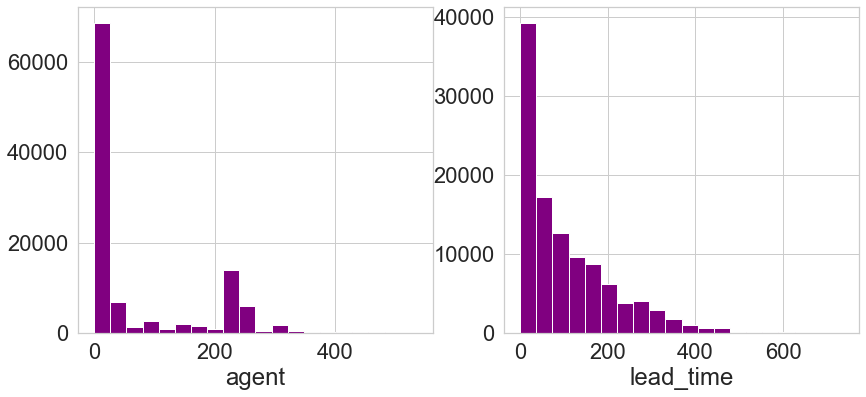

In [196]:
import pylab

#уберем дискретные признаки
count_cols = ['agent', 'lead_time']

plt.figure(figsize=(14,6))

for i,j in zip(count_cols, np.arange(1,len(count_cols)+1)):
    
    df_new = hotel_full[i]
    pylab.subplot(len(count_cols)//2,2,j)
    pylab.hist(df_new,bins=20, color='purple')
    plt.xlabel(i);

#### Вывод: выбросов в данных нет

#### Посмотрим на распределение дискретных признаков

In [197]:
hotel_full['reservation_status_date'] = pd.to_datetime(hotel_full['reservation_status_date'])

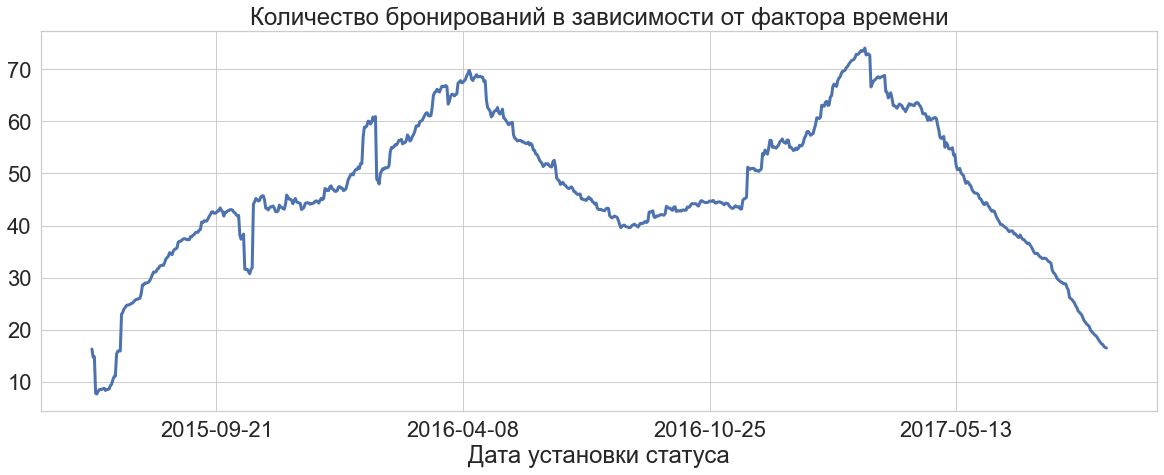

In [198]:
hotel_train.groupby('reservation_status_date').is_canceled.sum().rolling(100).mean().plot(linewidth=3)
plt.title('Количество бронирований в зависимости от фактора времени')
plt.xlabel('Дата установки статуса');

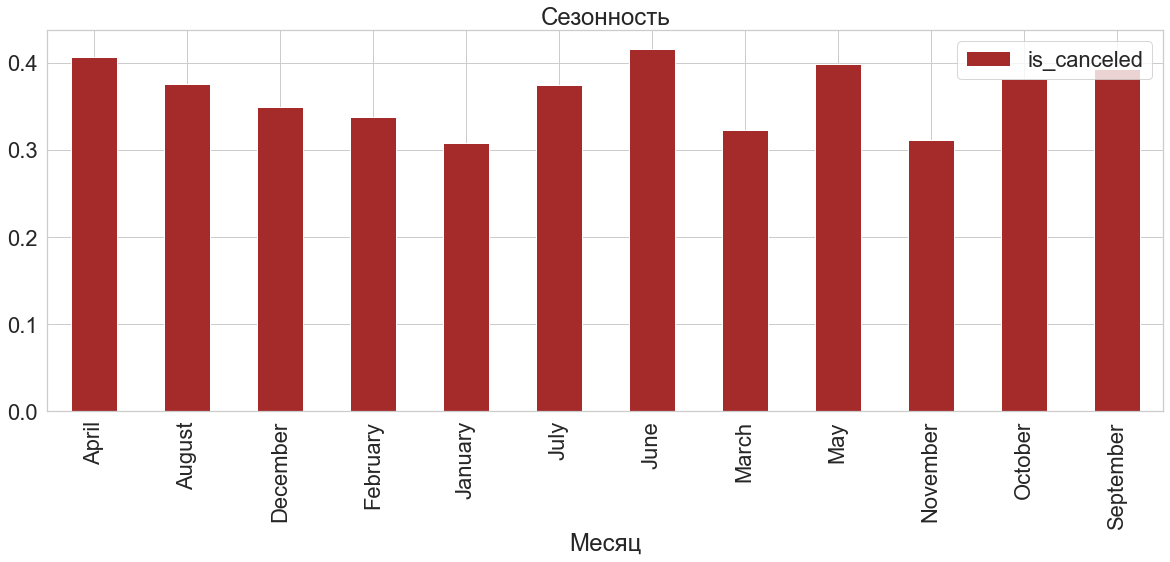

In [199]:
hotel_train.groupby('arrival_date_month').agg({'is_canceled':'mean'}).plot(kind='bar', color='brown')
plt.title('Сезонность')
plt.xlabel('Месяц');

#### Мы видим, что распределение по месяцам и график количества бронирований наглядно иллюстрируют сезонность и являются мультиколлинеарными, поэтому для упрощения работы уберем фактор времени

In [200]:
hotel_full.drop('reservation_status_date',axis=1,inplace=True)

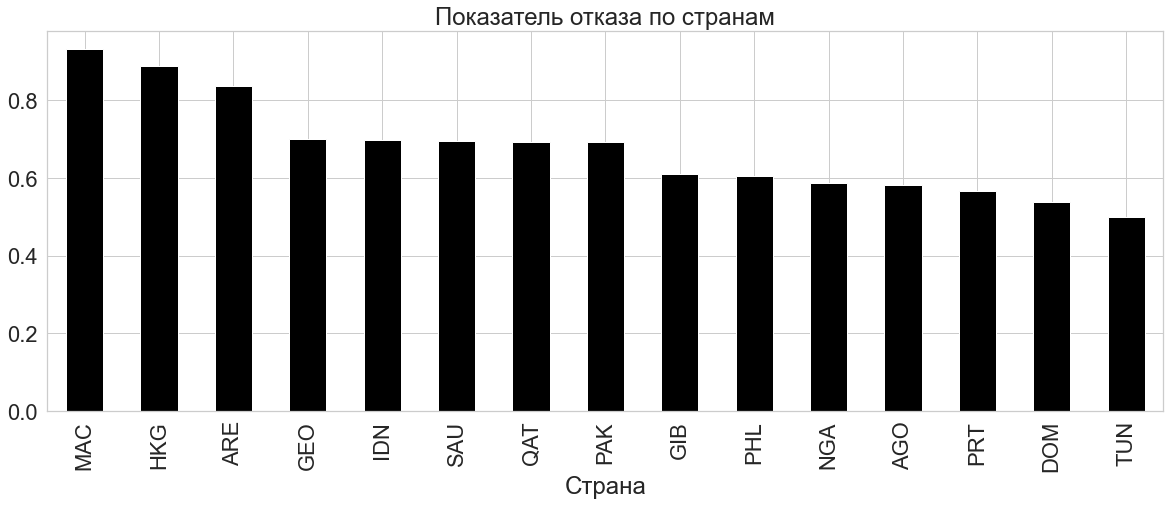

In [201]:
country_df = hotel_full.groupby('country').agg({'is_canceled': ['count','mean']}).rename({'is_canceled':'count'},axis=1)
country_med = country_df.median().values[0]
country_df.columns = ['count', 'mean']
country_df.query('count>@country_med')['mean'] \
            .sort_values(ascending=False).head(15).plot(kind='bar', color='black')
plt.title('Показатель отказа по странам')
plt.xlabel('Страна');

#### Посмотрим на среднее значение вероятности отказа по странам, на графике выведены страны с самым высоким процентом отказов (мы взяли страны с показателем количества бронирований больше медианного, так как распределение ненормальное, в нем присутствуют выбросы, то есть например 1 бронирование на всю страну)

#### Проведем похожие процедуры для остальных дискретных признаков

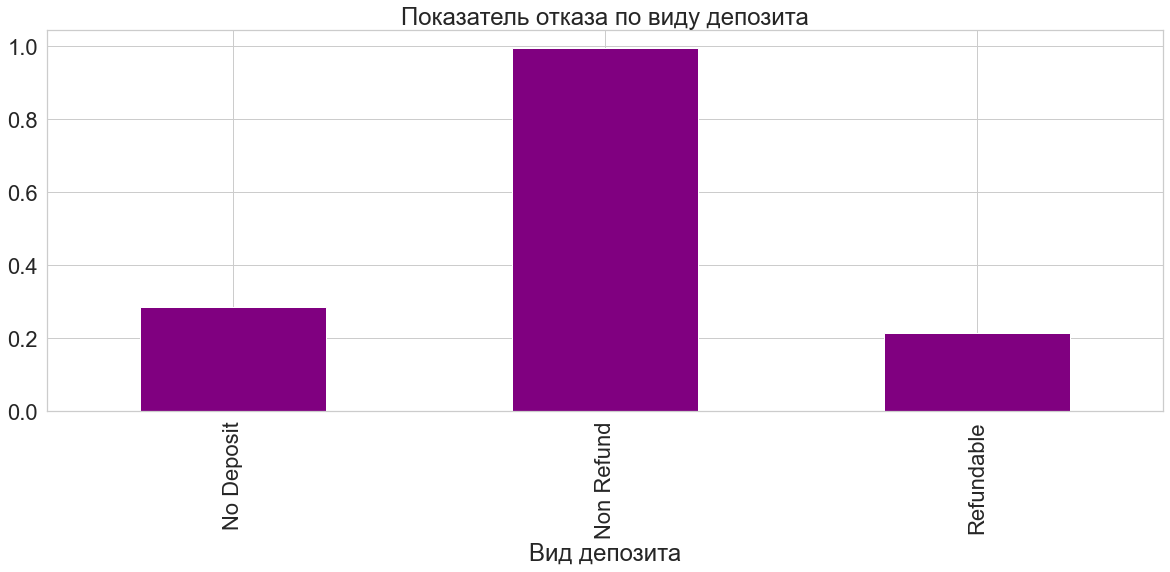

In [202]:
hotel_full.groupby('deposit_type').is_canceled.mean().plot(kind='bar', color='purple')
plt.title('Показатель отказа по виду депозита')
plt.xlabel('Вид депозита');

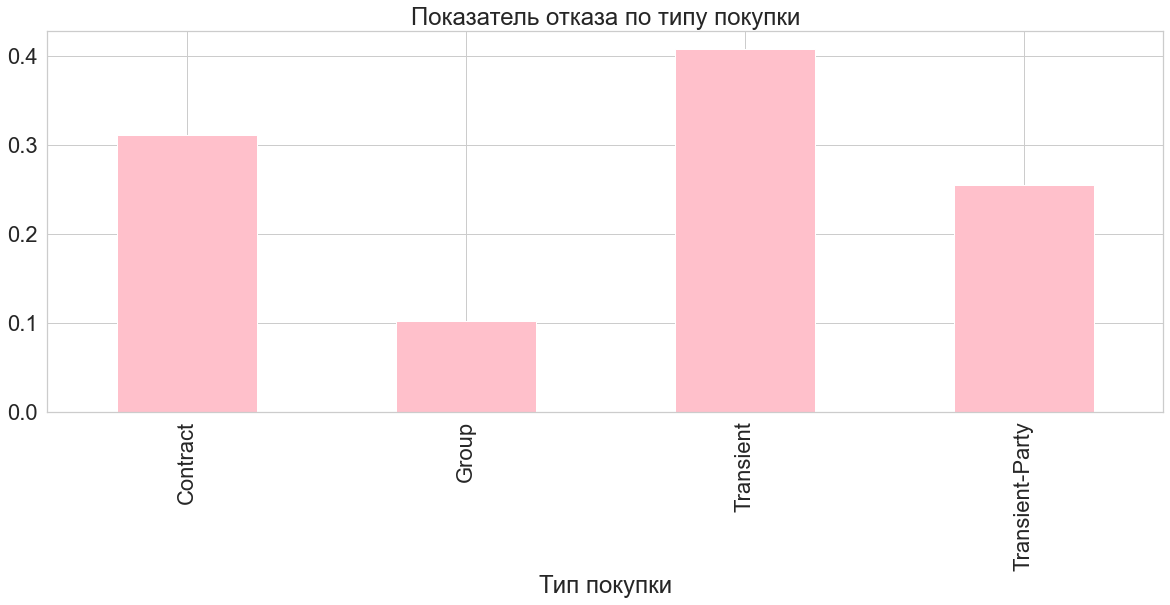

In [203]:
hotel_full.groupby('customer_type').is_canceled.mean().plot(kind='bar', color='pink')
plt.title('Показатель отказа по типу покупки')
plt.xlabel('Тип покупки');

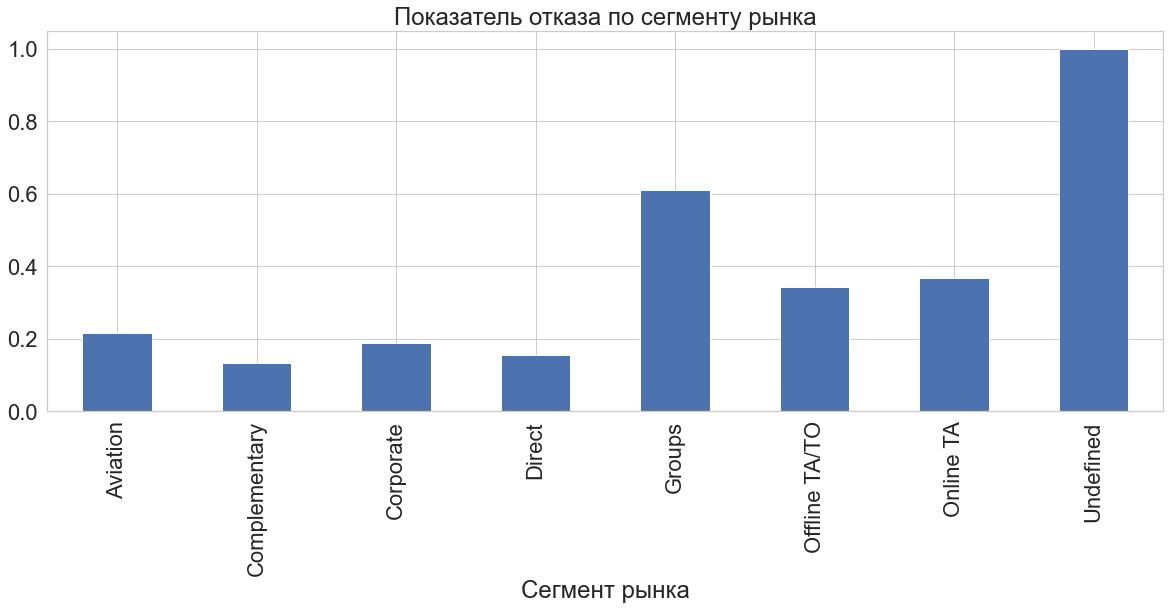

In [204]:
hotel_full.groupby('market_segment').is_canceled.mean().plot(kind='bar')
plt.title('Показатель отказа по сегменту рынка')
plt.xlabel('Сегмент рынка');

In [205]:
hotel_full.groupby('meal', as_index = False).is_canceled.count()

,meal,is_canceled
0,BB,84647
1,FB,724
2,HB,13212
3,SC,9729
4,Undefined,1078


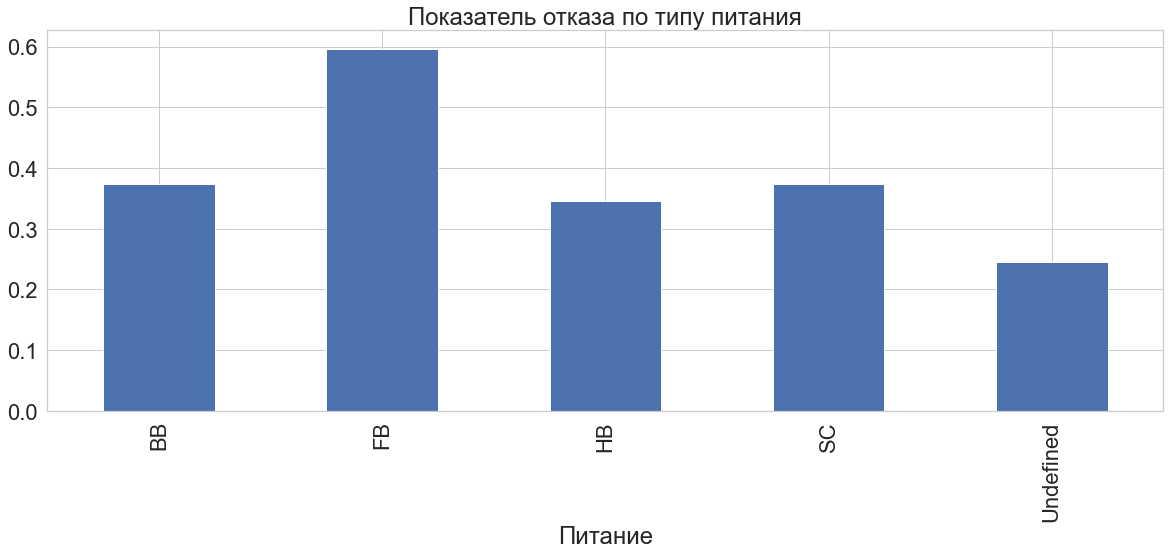

In [206]:
hotel_full.groupby('meal').is_canceled.mean().plot(kind='bar')
plt.title('Показатель отказа по типу питания')
plt.xlabel('Питание');

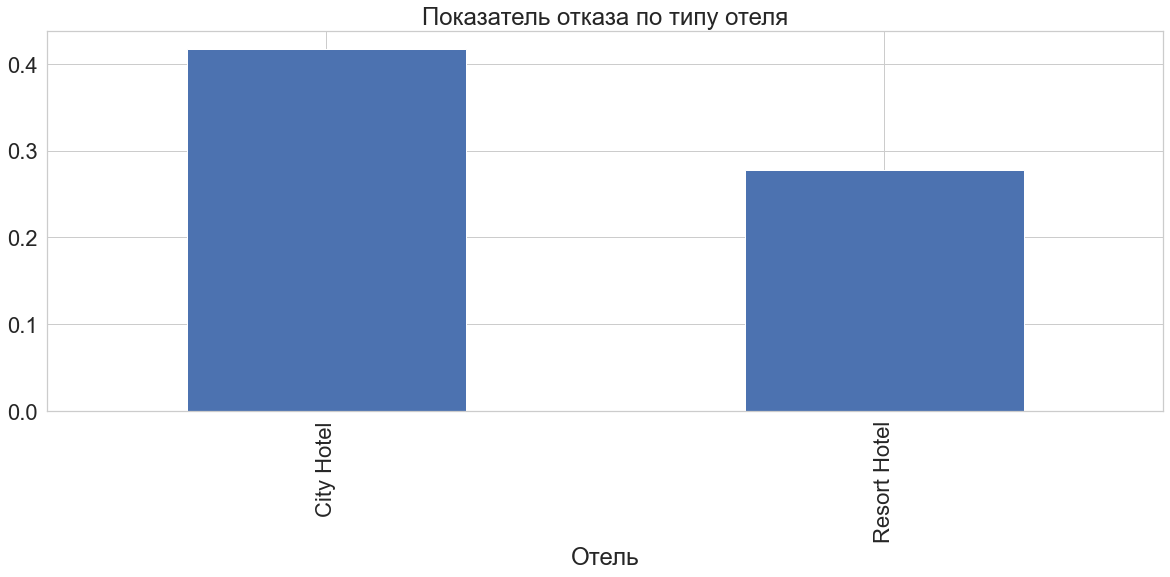

In [207]:
hotel_full.groupby('hotel').is_canceled.mean().plot(kind='bar')
plt.title('Показатель отказа по типу отеля')
plt.xlabel('Отель');

In [208]:
hotel_full.drop(['reserved_room_type','assigned_room_type'],axis=1, inplace=True)

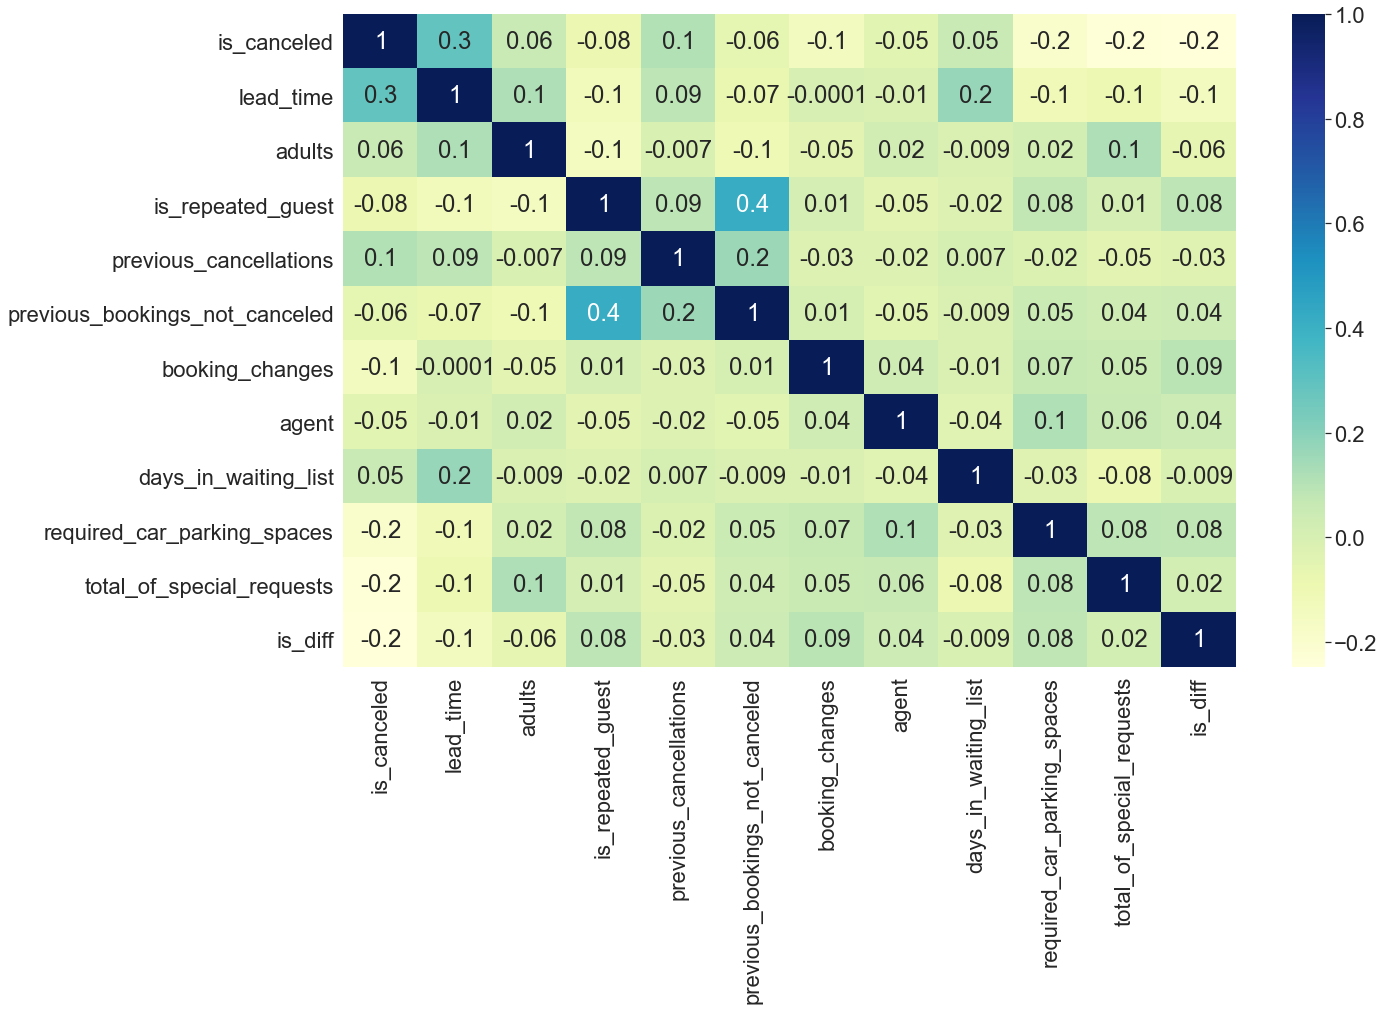

In [209]:
plt.figure(figsize=(20,12))
sns.heatmap(hotel_full.corr(method='pearson'),annot=True,cmap="YlGnBu", fmt='.1g')
plt.show()

In [210]:
hotel_full.drop(['previous_bookings_not_canceled', 'days_in_waiting_list'], axis=1, inplace=True)

### Переведем objectы в дамми-переменные

In [211]:
hotel_full['hotel'] = pd.get_dummies(hotel_train['hotel'])

In [212]:
def get_month_in_int(month):
    MonthInInts = pd.Series([1,2,3,4,5,6,7,8,9,10,11,12],
                            index=['January','February','March','April','May','June',
                                   'July', 'August','September','October','November','December'])
    return MonthInInts[month]

In [213]:
hotel_full['arrival_date_month'] = hotel_full.arrival_date_month.apply(get_month_in_int)

In [214]:
month_dumm = pd.get_dummies(hotel_full.arrival_date_month, prefix='arrival_date_month')

In [215]:
hotel_full = pd.concat([hotel_full, month_dumm], axis=1)

In [216]:
hotel_full.drop('arrival_date_month', axis=1, inplace=True)

In [217]:
meal_dumm = pd.get_dummies(hotel_full.meal, prefix='meal')

In [218]:
hotel_full = pd.concat([hotel_full, meal_dumm], axis=1)

In [219]:
hotel_full.drop('meal', axis=1, inplace=True)

In [220]:
country_dumm = pd.get_dummies(hotel_full.country, prefix='country')

In [221]:
hotel_full = pd.concat([hotel_full, country_dumm], axis=1)

In [222]:
hotel_full.drop('country', axis=1, inplace=True)

In [223]:
hotel_full.drop('distribution_channel',axis=1,inplace=True)

In [224]:
market_dumm = pd.get_dummies(hotel_full.market_segment, prefix='market_segment')

In [225]:
hotel_full = pd.concat([hotel_full, market_dumm], axis=1)

In [226]:
hotel_full.drop('market_segment', axis=1, inplace=True)

In [227]:
deposit_dumm = pd.get_dummies(hotel_full.deposit_type, prefix='deposit_type')

In [228]:
hotel_full = pd.concat([hotel_full, deposit_dumm], axis=1)

In [229]:
hotel_full.drop('deposit_type', axis=1, inplace=True)

In [230]:
customer_dumm = pd.get_dummies(hotel_full.customer_type, prefix='customer_type')

In [231]:
hotel_full = pd.concat([hotel_full, customer_dumm], axis=1)

In [232]:
hotel_full.drop('customer_type', axis=1, inplace=True)

In [233]:
hotel_full.shape

(109390, 219)

#### Наш датафрэйм готов, разделим его на train и test, исходя из начальных условий

In [234]:
X = hotel_full.drop('is_canceled',axis=1)
y = hotel_full['is_canceled'].values

#### Посмотрим на наличие дисбаланса классов в данных

In [235]:
print(len(y[y == 0]))
print(len(y[y == 1]))

68848
40542


#### Вывод: дисбаланса классов нет

#### Для построения модели сначала будем использовать градиентный бустинг с помощью библиотеки CatBoost

#### Разделим тренировочную часть еще на подтренировочную и подтестовую для оценки показателя ROC-AUC

In [236]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, recall_score, precision_score

import warnings
warnings.filterwarnings('ignore')

In [237]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)

In [238]:
cb = CatBoostClassifier()

In [239]:
gs_cb = GridSearchCV(cb, param_grid= {'iterations':[100,500,1000,1500],
                                      'depth':[3,6,9],
                                      'max_leaves':[10,50,64,100],
                                      'penalties_coefficient':[0.5,1,2]})

In [247]:
#gs_cb.fit(X_train, y_train)
gs_cb.best_params_

{'depth': 6,
 'iterations': 1500,
 'max_leaves': 64,
 'penalties_coefficient': 0.5}

In [248]:
y_pred_catboost = gs_cb.predict(X_test)

In [249]:
print(f'ROC-AUC score: {roc_auc_score(y_pred_catboost, y_test)}')
print(f'Precision score: {precision_score(y_pred_catboost, y_test)}')
print(f'Recall score: {recall_score(y_pred_catboost, y_test)}')

ROC-AUC score: 0.8685000041448119
Precision score: 0.804418581714173
Recall score: 0.8487875949630554


#### Теперь сравним данную модель с случайным лесом 

In [243]:
from sklearn.ensemble import RandomForestClassifier

ran_for = RandomForestClassifier()

gs_for = GridSearchCV(ran_for, param_grid= {'n_estimators':[10,50,100],
                                            'criterion':['gini','entropy'],
                                            'max_depth':[None,5,10],
                                            'min_samples_leaf':[1,5,10]})
                     
                     
gs_for.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10],
                         'min_samples_leaf': [1, 5, 10],
                         'n_estimators': [10, 50, 100]})

In [244]:
gs_for.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'min_samples_leaf': 1,
 'n_estimators': 100}

In [245]:
y_pred_forest = gs_for.predict(X_test)

In [246]:
print(f'ROC-AUC score: {roc_auc_score(y_pred_forest, y_test)}')
print(f'Precision score: {precision_score(y_pred_forest, y_test)}')
print(f'Recall score: {recall_score(y_pred_forest, y_test)}')

ROC-AUC score: 0.8693744798615596
Precision score: 0.8081664858467305
Recall score: 0.8486794407042982


#### По метрике ROC-AUC и Recall модель cлучайного леса немного лучше на тестовых данных, чем градиентный бустинг. Можем использовать ее в дальнейшем для предсказаний.